In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="white")

import requests
from bs4 import BeautifulSoup
from newspaper import Article 
from utils import *

In [2]:
FILEPATH = 'data/OnlineNewsPopularity.csv'
data = pd.read_csv(FILEPATH)

data['index'] = range(len(data))
data = data.set_index('index')
print(data.shape)

(39644, 61)


In [3]:
data.iloc[0]

url                              http://mashable.com/2013/01/07/amazon-instant-...
 timedelta                                                                     731
 n_tokens_title                                                                 12
 n_tokens_content                                                              219
 n_unique_tokens                                                          0.663594
                                                       ...                        
 title_subjectivity                                                            0.5
 title_sentiment_polarity                                                  -0.1875
 abs_title_subjectivity                                                          0
 abs_title_sentiment_polarity                                               0.1875
 shares                                                                        593
Name: 0, Length: 61, dtype: object

In [4]:
col = data.columns
col

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

### Selecting important features

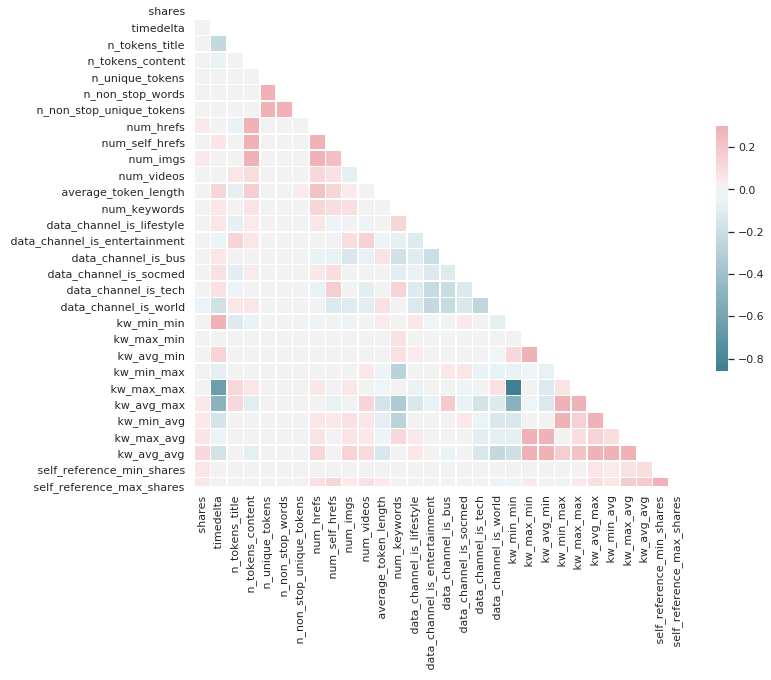

In [8]:
first_half = data[col[:30]]

first_half = pd.concat([data[' shares'], first_half], axis=1)

corr = first_half.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In the first 30 features, num_hrefs, num_imgs, data_channel_is_world, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference are correlated to shares.

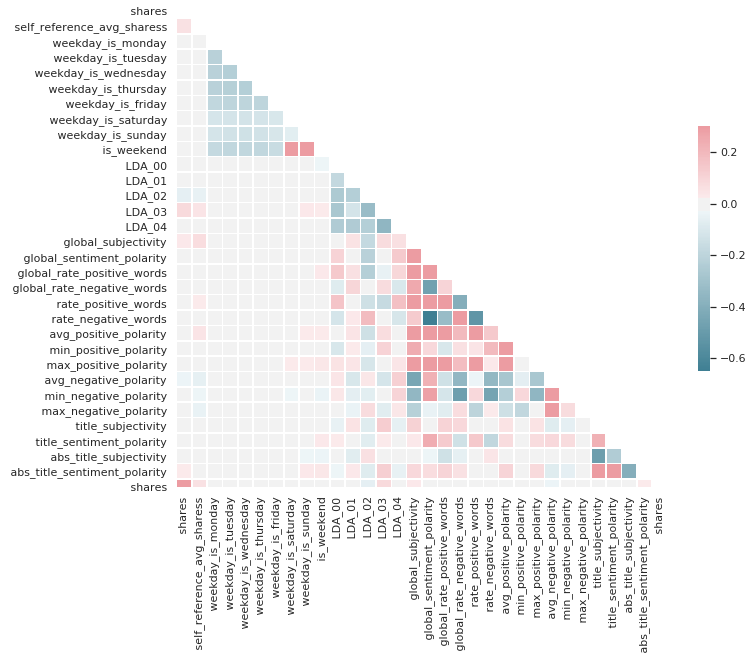

In [7]:
sec_half = data[col[30:]]

sec_half = pd.concat([data[' shares'], sec_half], axis=1)

corr = sec_half.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In later half of features, self_reference, LDA_02, LDA_03, global_subjectivity, avg_negetive_polarity are correlated to shares.

In [8]:
features = data[col].corr()[' shares'][:]
# features = np.array(features)
print("Positively correlated features: \n")
print(features[features>0.02]) 
print("\n\n Negatively correlated features: \n")
print(features[features< -0.02]) 

Positively correlated features: 

 num_hrefs                       0.045404
 num_imgs                        0.039388
 num_videos                      0.023936
 num_keywords                    0.021818
 kw_max_min                      0.030114
 kw_avg_min                      0.030406
 kw_avg_max                      0.044686
 kw_min_avg                      0.039551
 kw_max_avg                      0.064306
 kw_avg_avg                      0.110413
 self_reference_min_shares       0.055958
 self_reference_max_shares       0.047115
 self_reference_avg_sharess      0.057789
 LDA_03                          0.083771
 global_subjectivity             0.031604
 title_subjectivity              0.021967
 abs_title_sentiment_polarity    0.027135
 shares                          1.000000
Name:  shares, dtype: float64


 Negatively correlated features: 

 average_token_length    -0.022007
 data_channel_is_world   -0.049497
 LDA_02                  -0.059163
 avg_negative_polarity   -0.032029
Nam

In [39]:
data[' shares'].describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64

Rather than predicting the actual number of shares, we may predict, whether the number of shares is high or low.<br/>
<br/>
(shares < 950)                    : low <br/>
(shares > 950  and shares < 1400) : intermediate <br/>
(shares > 1400 and shares < 2800) : high <br/>
(shares > 2800 and shares < 10000) : very high <br/>
(shares > 10000)                  : vv high 

Fitting a baseline NN, with all features included.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def clean_cols(data):
    """Clean the column names by stripping and lowercase."""
    clean_col_map = {x: x.lower().strip() for x in list(data)}
    return data.rename(columns=clean_col_map)

def TrainTestSplit(X, Y, R=0, test_size=0.2):
    """Easy Train Test Split call."""
    return train_test_split(X, Y, test_size=test_size, random_state=R)

In [25]:
full_data = clean_cols(data)
train_set, test_set = train_test_split(full_data, test_size=0.20, random_state=42)

# x_train = train_set.drop(['shares', 'url'], axis=1)
# y_train = train_set['shares']

# x_test = test_set.drop(['shares', 'url'], axis=1)
# y_test = test_set['shares']

x_train = train_set.drop(['url','shares', 'timedelta', 'lda_00','lda_01','lda_02','lda_03','lda_04','num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','rate_positive_words','rate_negative_words','abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)
y_train = train_set['shares']

x_test = test_set.drop(['url','shares', 'timedelta', 'num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','rate_positive_words','rate_negative_words','abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)
y_test = test_set['shares']

print(x_train.shape)
x_train.head()

(31715, 36)


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,global_rate_positive_words,global_rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity
index,,,,,,,,,,,,,,,,,,,,,
19837,15.0,628.0,0.509709,1.0,0.645084,14.0,1.0,0.0,5.090764,7.0,...,0.025478,0.011146,0.275971,0.033333,0.8,-0.259184,-0.500000,-0.100000,0.458333,0.333333
904,11.0,409.0,0.519608,1.0,0.657480,2.0,1.0,0.0,4.958435,4.0,...,0.046455,0.017115,0.295343,0.136364,0.5,-0.133333,-0.166667,-0.100000,0.000000,0.000000
23876,7.0,345.0,0.609329,1.0,0.783920,5.0,1.0,0.0,4.942029,5.0,...,0.049275,0.011594,0.428715,0.062500,0.6,-0.282639,-0.800000,-0.050000,0.000000,0.000000
22966,11.0,217.0,0.580189,1.0,0.775000,8.0,3.0,0.0,4.520737,7.0,...,0.069124,0.009217,0.325667,0.033333,0.5,-0.098214,-0.125000,-0.071429,0.550000,0.200000
4705,13.0,123.0,0.739837,1.0,0.887324,3.0,1.0,0.0,4.479675,4.0,...,0.040650,0.016260,0.444524,0.200000,1.0,-0.550000,-1.000000,-0.100000,0.000000,0.000000


In [26]:
from keras import Input, Model
from keras.layers import Add, Dropout, concatenate,Flatten,Dense
from keras.layers import Reshape, LeakyReLU
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
from keras.utils import plot_model
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.models import Model,load_model
from keras.layers.core import Reshape,Flatten,Dense
from keras.layers.merge import Concatenate
import keras_contrib.backend as KC
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import sys
import keras
import cv2
from keras.layers.core import Lambda
from scipy import misc
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [30]:
def return_model():

    I = Input(shape=(36,))
    
    z1 = Dense(96, activation="tanh")(I)
    z1 = Dense(64, activation='tanh')(z1)
    z1 = Dense(12, activation='relu')(z1)
    z2 = Dense(1, activation='relu')(z1)

    model = Model(inputs=[I], outputs=[z2])

    return model

In [31]:
model = return_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 96)                3552      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_7 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer = "adam", 
              loss = "mse", 
              metrics = ["accuracy"])

model.fit(x = x_train, y = y_train, epochs = 1000)

W0427 06:54:30.989176 139945523255040 deprecation_wrapper.py:119] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0427 06:54:31.139129 139945523255040 deprecation_wrapper.py:119] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1000
31715/31715 [==============================] - 23s 731us/step - loss: 148720015.8234 - acc: 9.4592e-05
Epoch 2/1000
31715/31715 [==============================] - 6s 175us/step - loss: 142671717.9013 - acc: 3.4684e-04
Epoch 3/1000
31715/31715 [==============================] - 5s 164us/step - loss: 139494958.4485 - acc: 9.4592e-05
Epoch 4/1000
31715/31715 [==============================] - 5s 165us/step - loss: 138882885.2015 - acc: 0.0000e+00
Epoch 5/1000
31715/31715 [==============================] - 5s 163us/step - loss: 138819103.9323 - acc: 0.0000e+00
Epoch 6/1000
31715/31715 [==============================] - 5s 167us/step - loss: 138820648.9765 - acc: 9.4592e-05
Epoch 7/1000
31715/31715 [==============================] - 6s 196us/step - loss: 138827789.1955 - acc: 4.0990e-04
Epoch 8/1000
31715/31715 [==============================] - 6s 185us/step - loss: 138807157.6438 - acc: 3.1531e-05
Epoch 9/1000
31715/31715 [==============================] - 7s 208us/step - los

31715/31715 [==============================] - 6s 204us/step - loss: 137506820.9318 - acc: 1.2612e-04
Epoch 72/1000
31715/31715 [==============================] - 5s 167us/step - loss: 137413241.4840 - acc: 9.4592e-05
Epoch 73/1000
31715/31715 [==============================] - 5s 167us/step - loss: 137341249.7192 - acc: 1.2612e-04
Epoch 74/1000
31715/31715 [==============================] - 5s 165us/step - loss: 137386505.7115 - acc: 2.2072e-04
Epoch 75/1000
31715/31715 [==============================] - 5s 165us/step - loss: 137326620.0620 - acc: 9.4592e-05
Epoch 76/1000
31715/31715 [==============================] - 5s 164us/step - loss: 137302878.3234 - acc: 3.1531e-05
Epoch 77/1000
31715/31715 [==============================] - 5s 167us/step - loss: 137230583.8130 - acc: 1.2612e-04
Epoch 78/1000
31715/31715 [==============================] - 5s 165us/step - loss: 136850002.3837 - acc: 3.4684e-04
Epoch 79/1000
31715/31715 [==============================] - 5s 164us/step - loss: 137

31715/31715 [==============================] - 5s 160us/step - loss: 136771741.6865 - acc: 1.2612e-04
Epoch 142/1000
31715/31715 [==============================] - 5s 157us/step - loss: 137084271.6243 - acc: 0.0000e+00
Epoch 143/1000
31715/31715 [==============================] - 5s 159us/step - loss: 136692062.5149 - acc: 6.3062e-05
Epoch 144/1000
31715/31715 [==============================] - 5s 157us/step - loss: 136883232.1015 - acc: 6.3062e-05
Epoch 145/1000
31715/31715 [==============================] - 5s 158us/step - loss: 136801429.0534 - acc: 9.4592e-05
Epoch 146/1000
31715/31715 [==============================] - 5s 158us/step - loss: 136828089.5264 - acc: 3.1531e-05
Epoch 147/1000
31715/31715 [==============================] - 5s 158us/step - loss: 137049699.0480 - acc: 9.4592e-05
Epoch 148/1000
31715/31715 [==============================] - 5s 157us/step - loss: 136682664.4420 - acc: 2.2072e-04
Epoch 149/1000
31715/31715 [==============================] - 5s 158us/step - l

31715/31715 [==============================] - 5s 162us/step - loss: 136256379.3552 - acc: 1.2612e-04
Epoch 212/1000
31715/31715 [==============================] - 5s 160us/step - loss: 136067999.3711 - acc: 3.1531e-05
Epoch 213/1000
31715/31715 [==============================] - 5s 158us/step - loss: 135969464.6170 - acc: 6.3062e-05
Epoch 214/1000
31715/31715 [==============================] - 5s 159us/step - loss: 136096035.5864 - acc: 3.1531e-05
Epoch 215/1000
31715/31715 [==============================] - 5s 157us/step - loss: 136223961.9811 - acc: 3.1531e-05
Epoch 216/1000
31715/31715 [==============================] - 5s 159us/step - loss: 136074820.3281 - acc: 9.4592e-05
Epoch 217/1000
31715/31715 [==============================] - 5s 158us/step - loss: 136113303.1119 - acc: 1.5765e-04
Epoch 218/1000
31715/31715 [==============================] - 5s 158us/step - loss: 136591218.9286 - acc: 6.3062e-05
Epoch 219/1000
31715/31715 [==============================] - 5s 158us/step - l

31715/31715 [==============================] - 5s 162us/step - loss: 135581687.7635 - acc: 3.1531e-05
Epoch 282/1000
31715/31715 [==============================] - 5s 162us/step - loss: 135138588.7347 - acc: 6.3062e-05
Epoch 283/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134865710.4517 - acc: 6.3062e-05
Epoch 284/1000
31715/31715 [==============================] - 5s 158us/step - loss: 135276677.6178 - acc: 6.3062e-05
Epoch 285/1000
31715/31715 [==============================] - 5s 158us/step - loss: 135145916.1192 - acc: 1.8918e-04
Epoch 286/1000
31715/31715 [==============================] - 5s 159us/step - loss: 135506134.7727 - acc: 3.1531e-05
Epoch 287/1000
31715/31715 [==============================] - 5s 158us/step - loss: 135500690.0874 - acc: 1.5765e-04
Epoch 288/1000
31715/31715 [==============================] - 5s 159us/step - loss: 135660476.7801 - acc: 6.3062e-05
Epoch 289/1000
31715/31715 [==============================] - 5s 158us/step - l

31715/31715 [==============================] - 5s 161us/step - loss: 135450401.2680 - acc: 0.0000e+00
Epoch 352/1000
31715/31715 [==============================] - 5s 161us/step - loss: 134723862.2159 - acc: 1.5765e-04
Epoch 353/1000
31715/31715 [==============================] - 5s 165us/step - loss: 134759427.0252 - acc: 9.4592e-05
Epoch 354/1000
31715/31715 [==============================] - 5s 159us/step - loss: 134483924.3807 - acc: 1.2612e-04
Epoch 355/1000
31715/31715 [==============================] - 5s 161us/step - loss: 134314292.7190 - acc: 1.2612e-04
Epoch 356/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134306516.4730 - acc: 3.1531e-05
Epoch 357/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134154024.0231 - acc: 2.8378e-04
Epoch 358/1000
31715/31715 [==============================] - 5s 157us/step - loss: 134622887.6698 - acc: 9.4592e-05
Epoch 359/1000
31715/31715 [==============================] - 5s 158us/step - l

31715/31715 [==============================] - 5s 160us/step - loss: 134045908.7755 - acc: 3.1531e-05
Epoch 422/1000
31715/31715 [==============================] - 5s 167us/step - loss: 134089548.1858 - acc: 6.3062e-05
Epoch 423/1000
31715/31715 [==============================] - 5s 165us/step - loss: 134505042.2016 - acc: 6.3062e-05
Epoch 424/1000
31715/31715 [==============================] - 5s 161us/step - loss: 133915119.0768 - acc: 3.1531e-05
Epoch 425/1000
31715/31715 [==============================] - 5s 156us/step - loss: 134087405.6936 - acc: 1.2612e-04
Epoch 426/1000
31715/31715 [==============================] - 5s 159us/step - loss: 134167095.7758 - acc: 6.3062e-05
Epoch 427/1000
31715/31715 [==============================] - 5s 156us/step - loss: 134165643.5037 - acc: 6.3062e-05
Epoch 428/1000
31715/31715 [==============================] - 5s 159us/step - loss: 134170988.3768 - acc: 9.4592e-05
Epoch 429/1000
31715/31715 [==============================] - 5s 158us/step - l

31715/31715 [==============================] - 5s 159us/step - loss: 134408925.6817 - acc: 3.1531e-05
Epoch 492/1000
31715/31715 [==============================] - 5s 160us/step - loss: 133554153.6134 - acc: 0.0000e+00
Epoch 493/1000
31715/31715 [==============================] - 5s 161us/step - loss: 133532837.0565 - acc: 1.2612e-04
Epoch 494/1000
31715/31715 [==============================] - 5s 163us/step - loss: 133128978.7076 - acc: 1.2612e-04
Epoch 495/1000
31715/31715 [==============================] - 5s 159us/step - loss: 134182715.2277 - acc: 3.1531e-05
Epoch 496/1000
31715/31715 [==============================] - 5s 156us/step - loss: 133863313.9261 - acc: 1.2612e-04
Epoch 497/1000
31715/31715 [==============================] - 5s 161us/step - loss: 134497128.0810 - acc: 9.4592e-05
Epoch 498/1000
31715/31715 [==============================] - 5s 156us/step - loss: 134621079.5207 - acc: 9.4592e-05
Epoch 499/1000
31715/31715 [==============================] - 5s 159us/step - l

31715/31715 [==============================] - 5s 159us/step - loss: 134341625.8761 - acc: 3.1531e-05
Epoch 561/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134489410.9875 - acc: 6.3062e-05
Epoch 562/1000
31715/31715 [==============================] - 5s 157us/step - loss: 133754536.6185 - acc: 1.5765e-04
Epoch 563/1000
31715/31715 [==============================] - 5s 164us/step - loss: 133945260.8523 - acc: 6.3062e-05
Epoch 564/1000
31715/31715 [==============================] - 5s 165us/step - loss: 134076932.4689 - acc: 6.3062e-05
Epoch 565/1000
31715/31715 [==============================] - 5s 161us/step - loss: 133912656.5194 - acc: 6.3062e-05
Epoch 566/1000
31715/31715 [==============================] - 5s 159us/step - loss: 134120807.3713 - acc: 3.1531e-05
Epoch 567/1000
31715/31715 [==============================] - 5s 158us/step - loss: 133773384.1778 - acc: 9.4592e-05
Epoch 568/1000
31715/31715 [==============================] - 5s 158us/step - l

31715/31715 [==============================] - 5s 159us/step - loss: 134972390.6531 - acc: 1.2612e-04
Epoch 631/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134171711.4655 - acc: 6.3062e-05
Epoch 632/1000
31715/31715 [==============================] - 5s 157us/step - loss: 134479013.1869 - acc: 6.3062e-05
Epoch 633/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134525504.0221 - acc: 1.8918e-04
Epoch 634/1000
31715/31715 [==============================] - 5s 163us/step - loss: 134012835.3159 - acc: 0.0000e+00
Epoch 635/1000
31715/31715 [==============================] - 5s 162us/step - loss: 134668642.3643 - acc: 1.8918e-04
Epoch 636/1000
31715/31715 [==============================] - 5s 163us/step - loss: 134263279.1701 - acc: 9.4592e-05
Epoch 637/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134266550.0761 - acc: 6.3062e-05
Epoch 638/1000
31715/31715 [==============================] - 5s 159us/step - l

31715/31715 [==============================] - 5s 158us/step - loss: 134051483.2925 - acc: 1.2612e-04
Epoch 701/1000
31715/31715 [==============================] - 5s 159us/step - loss: 134249763.9178 - acc: 3.1531e-05
Epoch 702/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134211659.9753 - acc: 9.4592e-05
Epoch 703/1000
31715/31715 [==============================] - 5s 160us/step - loss: 133839746.6631 - acc: 9.4592e-05
Epoch 704/1000
31715/31715 [==============================] - 5s 158us/step - loss: 134304286.9040 - acc: 2.2072e-04
Epoch 705/1000
31715/31715 [==============================] - 5s 164us/step - loss: 133959190.9563 - acc: 1.5765e-04
Epoch 706/1000
31715/31715 [==============================] - 5s 160us/step - loss: 133891619.0166 - acc: 1.5765e-04
Epoch 707/1000
31715/31715 [==============================] - 5s 160us/step - loss: 134598431.2480 - acc: 3.1531e-05
Epoch 708/1000
31715/31715 [==============================] - 5s 157us/step - l

31715/31715 [==============================] - 5s 160us/step - loss: 133681661.2855 - acc: 3.1531e-05
Epoch 771/1000
31715/31715 [==============================] - 5s 159us/step - loss: 133920641.8206 - acc: 9.4592e-05
Epoch 772/1000
31715/31715 [==============================] - 5s 160us/step - loss: 133933159.8162 - acc: 0.0000e+00
Epoch 773/1000
31715/31715 [==============================] - 5s 158us/step - loss: 133662700.4502 - acc: 6.3062e-05
Epoch 774/1000
31715/31715 [==============================] - 5s 159us/step - loss: 134406372.8094 - acc: 3.1531e-05
Epoch 775/1000
31715/31715 [==============================] - 7s 218us/step - loss: 133614141.5445 - acc: 3.1531e-05
Epoch 776/1000
31715/31715 [==============================] - 6s 204us/step - loss: 134320587.4905 - acc: 1.8918e-04
Epoch 777/1000
31715/31715 [==============================] - 5s 147us/step - loss: 133740261.8981 - acc: 3.1531e-05
Epoch 778/1000
31715/31715 [==============================] - 5s 146us/step - l

31715/31715 [==============================] - 5s 146us/step - loss: 134073474.6936 - acc: 6.3062e-05
Epoch 841/1000
31715/31715 [==============================] - 5s 147us/step - loss: 133995012.9001 - acc: 1.5765e-04
Epoch 842/1000
31715/31715 [==============================] - 5s 144us/step - loss: 134269845.1009 - acc: 0.0000e+00
Epoch 843/1000
31715/31715 [==============================] - 5s 144us/step - loss: 134732153.7062 - acc: 3.1531e-05
Epoch 844/1000
31715/31715 [==============================] - 5s 145us/step - loss: 133993320.3687 - acc: 6.3062e-05
Epoch 845/1000
31715/31715 [==============================] - 5s 145us/step - loss: 133922234.9646 - acc: 6.3062e-05
Epoch 846/1000
31715/31715 [==============================] - 5s 143us/step - loss: 134004894.5117 - acc: 0.0000e+00
Epoch 847/1000
31715/31715 [==============================] - 5s 145us/step - loss: 134337702.7982 - acc: 3.1531e-05
Epoch 848/1000
31715/31715 [==============================] - 5s 145us/step - l

31715/31715 [==============================] - 5s 144us/step - loss: 133747520.4942 - acc: 9.4592e-05
Epoch 911/1000
31715/31715 [==============================] - 5s 144us/step - loss: 133676519.7688 - acc: 0.0000e+00
Epoch 912/1000
31715/31715 [==============================] - 5s 144us/step - loss: 133840143.8746 - acc: 1.5765e-04
Epoch 913/1000
31715/31715 [==============================] - 5s 143us/step - loss: 133732974.2720 - acc: 3.1531e-05
Epoch 914/1000
31715/31715 [==============================] - 5s 145us/step - loss: 133390212.8414 - acc: 9.4592e-05
Epoch 915/1000
31715/31715 [==============================] - 5s 144us/step - loss: 134170359.1207 - acc: 6.3062e-05
Epoch 916/1000
31715/31715 [==============================] - 5s 145us/step - loss: 133432593.1750 - acc: 1.5765e-04
Epoch 917/1000
31715/31715 [==============================] - 5s 143us/step - loss: 133666626.0852 - acc: 2.2072e-04
Epoch 918/1000
31715/31715 [==============================] - 5s 146us/step - l

31715/31715 [==============================] - 5s 145us/step - loss: 133774579.0926 - acc: 3.1531e-05
Epoch 981/1000
31715/31715 [==============================] - 5s 150us/step - loss: 133811669.9265 - acc: 3.1531e-05
Epoch 982/1000
31715/31715 [==============================] - 5s 147us/step - loss: 133806882.9732 - acc: 9.4592e-05
Epoch 983/1000
31715/31715 [==============================] - 5s 149us/step - loss: 133993219.6556 - acc: 3.1531e-05
Epoch 984/1000
31715/31715 [==============================] - 5s 145us/step - loss: 133543086.3069 - acc: 0.0000e+00
Epoch 985/1000
31715/31715 [==============================] - 5s 144us/step - loss: 134636681.4352 - acc: 6.3062e-05
Epoch 986/1000
31715/31715 [==============================] - 5s 145us/step - loss: 133739933.9021 - acc: 3.1531e-05
Epoch 987/1000
31715/31715 [==============================] - 5s 145us/step - loss: 133529017.6551 - acc: 1.8918e-04
Epoch 988/1000
31715/31715 [==============================] - 5s 145us/step - l

In [33]:
model.save_weights("./data/wt_96_64_12.h5")

In [35]:
preds = model.evaluate(x = x_test, y = y_test)
print ("Loss = " + str(preds[0]))
print ("accuracy = " + str(preds[1]))

ValueError: Error when checking input: expected input_2 to have shape (36,) but got array with shape (41,)

In [ ]:
res = pd.DataFrame(model.predict(x_train),list(y_train))
res.reset_index(level=0, inplace=True)
res_df = res.rename(index=str, columns={"index": "Actual shares", 0: "Predicted shares"})
res_df.head()

----------------------------------------

---------------------

### Scraping articles form news website and Pre-processing

In [5]:
from utils import *

In [6]:
url = "https://in.mashable.com/"
r = requests.get(url)

soup = BeautifulSoup(r.content, 'html5lib') 
table = soup.findAll('a', attrs = {'class':'lnk'})

news = []
for url in table:
    news.append(url['href'])

news[:5]

['https://in.mashable.com/entertainment/13471/bad-education-review-hugh-jackman-allison-janney-deliver-a-masterclass-in-good-performance',
 'https://in.mashable.com/science/13474/chinese-biotechs-covid-19-vaccine-can-protect-monkeys-claims-report',
 'https://in.mashable.com/entertainment/13466/never-have-i-ever-review-mindy-kalings-netflix-teen-comedy-goes-down-like-a-smooth-shot',
 'https://in.mashable.com/science/13470/brussels-scientists-claim-coronavirus-lockdown-has-led-to-reduced-seismic-noise',
 'https://in.mashable.com/tech/13473/apple-watch-arrived-5-years-ago-and-it-changed-the-segment-forever']

In [7]:
dt = []
for url in news:
    article = Article(url, language="en")
    article.download() 
    article.parse() 
    article.nlp() 
    df={}
    df['Title']=article.title
    df['Text']=article.text
    df['Summary']=article.summary
    df['Keywords']=article.keywords
    dt.append(df)

In [8]:
dataset=pd.DataFrame(dt)
dataset.head()

,Title,Text,Summary,Keywords
0,"‘Bad Education’ Review: Hugh Jackman, Allison ...",'Bad Education' is a gripping true crime story...,We’re watching Hugh Jackman fresh off his The ...,"[hugh, jackman, deliver, frank, review, bad, f..."
1,Chinese Biotech’s COVID-19 Vaccine Can Protect...,A vaccine candidate developed by a Beijing-bas...,A vaccine candidate developed by a Beijing-bas...,"[claims, report, control, vaccines, biotechs, ..."
2,Never Have I Ever Review: Mindy Kaling’s Netfl...,Netflix's 'Never Have I Ever' is a show that p...,I was excited for this new offering from Netfl...,"[mindy, smooth, goes, shot, indian, love, trop..."
3,Brussels Scientists Claim Coronavirus Lockdown...,Scientists from the Royal Observatory of Belgi...,Something that is observed only during holiday...,"[scientists, activity, claim, brussels, reduct..."
4,Apple Watch Arrived 5 Years Ago And It Changed...,Just as Tim Cook finished his presentation on ...,But successive iterations of the Apple Watch h...,"[apples, product, smartwatch, arrived, users, ..."


In [9]:
dataset['Summary'][2]

'I was excited for this new offering from Netflix, because Mindy Kaling was behind it, and that trailer was funny and clever.\nDevi Vishwakumar (Maitreyi Ramakrishnan) is a 15-year-old first generation Indian American girl, living in California, about to begin her sophomore year in high school.\nThe WritingThe series benefits from several writers, including Mindy Kaling and Lang Fisher (he wrote on The Mindy Project).\nBut her nerdiness isn’t dismissed as a by-product of her being ‘Asian’ like most teen drama tropes do.\nDevi’s rebellions are another facet of her ethnicity that highlight the ‘Indian’ in her ‘Indian American’ identity.'

In [10]:
df2=[]
for i in news:
    pred_info={}
    article = Article(i, language="en") 
    article.download() 
    article.parse()
    analysis=TextBlob(article.text)
    polarity=analysis.sentiment.polarity
    title_analysis=TextBlob(article.title)
    pred_info['text']=article.text
    pred_info['n_tokens_title']=len(tokenize(article.title))
    pred_info['n_tokens_content']=len(tokenize(article.text))
    pred_info['n_unique_tokens']=rate_unique(article.text)
    pred_info['n_non_stop_words']=rate_nonstop(article.text)[0]
    pred_info['n_non_stop_unique_tokens']=rate_nonstop(article.text)[1]
    pred_info['num_hrefs']=article.html.count("https://timesofindia.indiatimes.com")
    pred_info['num_imgs']=len(article.images)
    pred_info['num_videos']=len(article.movies)
    pred_info['average_token_length']=avg_token(article.text)
    pred_info['num_keywords']=len(article.keywords)
    
    if "culture" in article.url:
        pred_info['data_channel_is_lifestyle']=1
    else:
        pred_info['data_channel_is_lifestyle']=0
    if "entertainment" in article.url:
        pred_info['data_channel_is_entertainment']=1
    else:
        pred_info['data_channel_is_entertainment']=0
    if "business" in article.url:
        pred_info['data_channel_is_bus']=1
    else:
        pred_info['data_channel_is_bus']=0
    if "social media" or "facebook" or "whatsapp" in article.text.lower():
        data_channel_is_socmed=1
        data_channel_is_tech=0
        data_channel_is_world=0
    else:
        data_channel_is_socmed=0
    if ("tech" in article.url):
        data_channel_is_tech=1
        data_channel_is_socmed=0
        data_channel_is_world=0
    else:
        data_channel_is_tech=0
    if "world" in article.url:
        data_channel_is_world=1
        data_channel_is_tech=0
        data_channel_is_socmed=0
    else:
        data_channel_is_world=0
        
    pred_info['data_channel_is_socmed']=data_channel_is_socmed
    pred_info['data_channel_is_tech']=data_channel_is_tech
    pred_info['data_channel_is_world']=data_channel_is_world
    
    if day(i)=="Monday":
        pred_info['weekday_is_monday']=1
    else:
        pred_info['weekday_is_monday']=0
    if day(i)=="Tuesday":
        pred_info['weekday_is_tuesday']=1
    else:
        pred_info['weekday_is_tuesday']=0
    if day(i)=="Wednesday":
        pred_info['weekday_is_wednesday']=1
    else:
        pred_info['weekday_is_wednesday']=0
    if day(i)=="Thursday":
        pred_info['weekday_is_thursday']=1
    else:
        pred_info['weekday_is_thursday']=0
    if day(i)=="Friday":
        pred_info['weekday_is_friday']=1
    else:
        pred_info['weekday_is_friday']=0
    if day(i)=="Saturday":
        pred_info['weekday_is_saturday']=1
        pred_info['is_weekend']=1
    else:
        pred_info['weekday_is_saturday']=0
    if day(i)=="Sunday":
        pred_info['weekday_is_sunday']=1
        pred_info['is_weekend']=1
    else:
        pred_info['weekday_is_sunday']=0
        pred_info['is_weekend']=0
        
    pred_info['global_subjectivity']=analysis.sentiment.subjectivity
    pred_info['global_sentiment_polarity']=analysis.sentiment.polarity
    pred_info['title_subjectivity']=title_analysis.sentiment.subjectivity
    pred_info['title_sentiment_polarity']=title_analysis.sentiment.polarity
    
    pred_info['global_rate_positive_words'] = rates(article.text)[0]
    pred_info['global_rate_negative_words']=rates(article.text)[1]
    pred_info['avg_positive_polarity']=rates(article.text)[2]
    pred_info['min_positive_polarity']=rates(article.text)[3]
    pred_info['max_positive_polarity']=rates(article.text)[4]
    pred_info['avg_negative_polarity']=rates(article.text)[5]
    pred_info['min_negative_polarity']=rates(article.text)[6]
    pred_info['max_negative_polarity']=rates(article.text)[7]    

    df2.append(pred_info)

In [15]:
pred_df=pd.DataFrame(df2)
pred_test=pred_df.drop(['text'],axis=1)
pred_df.head()

,text,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,...,title_subjectivity,title_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity
0,'Bad Education' is a gripping true crime story...,17,1386,0.422078,0.632756,0.363636,0,13,0,4.349206,...,0.633333,5.551115e-17,0.415,0.38,0.419262,0.062500,1.0,-0.452867,-1.0,-0.0500
1,A vaccine candidate developed by a Beijing-bas...,12,419,0.527446,0.677804,0.422434,0,8,0,4.706444,...,0.000000,0.000000e+00,3.375,1.53,0.412798,0.062500,1.0,-0.448940,-1.0,-0.0500
2,Netflix's 'Never Have I Ever' is a show that p...,19,2600,0.338077,0.624615,0.294231,0,12,0,3.997308,...,0.262963,8.148148e-02,4.385,1.90,0.406889,0.033333,1.0,-0.390172,-1.0,-0.0125
3,Scientists from the Royal Observatory of Belgi...,11,467,0.522484,0.700214,0.428266,0,8,0,4.899358,...,0.000000,0.000000e+00,8.820,3.04,0.408498,0.033333,1.0,-0.358665,-1.0,-0.0125
4,Just as Tim Cook finished his presentation on ...,12,2243,0.327240,0.613910,0.283995,0,12,1,4.316540,...,0.000000,0.000000e+00,9.625,3.56,0.411349,0.033333,1.0,-0.347490,-1.0,-0.0125


In [18]:
p_cols = pred_df.columns
p_cols

Index(['text', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend',
       'global_subjectivity', 'global_sentiment_polarity',
       'title_subjectivity', 'title_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity'],
      dtype='object')

In [24]:
col

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [ ]:
test2=pd.DataFrame(clf.predict(pred_test),pred_df['text'])
test2.reset_index(level=0, inplace=True)
test2 = test2.rename(index=str, columns={"index": "News", 0: "Virality"})
test2

In [48]:
# url = "https://in.mashable.com/"
# # url = "https://www.bbc.com/"
# url = "https://timesofindia.indiatimes.com/world"
# r = requests.get(url)

# soup = BeautifulSoup(r.content, 'html5lib') 
# table = soup.findAll('a', attrs = {'class':'w_img'})
# # table = soup.findAll('a', attrs = {'class':'lnk'})
# table

# news=[]
# for row in table: 
#     if not row['href'].startswith('http'):
#         news.append('https://timesofindia.indiatimes.com'+row['href'])      
# news

# dt=[]
# for i in news:
#     article = Article(i, language="en")
#     article.download() 
#     article.parse() 
#     article.nlp() 
#     df={}
#     df['Title']=article.title
#     df['Text']=article.text
#     df['Summary']=article.summary
#     df['Keywords']=article.keywords
#     dt.append(df)

# dataset=pd.DataFrame(dt)
# print(dataset.shape)
# dataset.head()

In [51]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split

# def clean_cols(data):
#     """Clean the column names by stripping and lowercase."""
#     clean_col_map = {x: x.lower().strip() for x in list(data)}
#     return data.rename(columns=clean_col_map)

# def TrainTestSplit(X, Y, R=0, test_size=0.2):
#     """Easy Train Test Split call."""
#     return train_test_split(X, Y, test_size=test_size, random_state=R)

# full_data = clean_cols(pd.read_csv(FILEPATH))
# train_set, test_set = train_test_split(full_data, test_size=0.20, random_state=42)

# x_train = train_set.drop(['url','shares', 'timedelta', 'lda_00','lda_01','lda_02','lda_03','lda_04','num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','rate_positive_words','rate_negative_words','abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)
# y_train = train_set['shares']

# x_test = test_set.drop(['url','shares', 'timedelta', 'num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','rate_positive_words','rate_negative_words','abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)
# y_test = test_set['shares']

# clf = RandomForestRegressor(random_state=42)
# clf.fit(x_train, y_train)

# rf_res = pd.DataFrame(clf.predict(x_train),list(y_train))
# rf_res.reset_index(level=0, inplace=True)
# rf_res_df = rf_res.rename(index=str, columns={"index": "Actual shares", 0: "Predicted shares"})
# rf_res_df.head()
